%register 'serial:///dev/serial0'
%connect robot-stm
%rsync
%softreset
# Robot - Motor Speed Control

In [1]:
%register 'serial:///dev/serial0'
%connect robot-stm

class C:
    def __init__(self, v):
        self.v = v
        
    def r(self):
        pass
    
    def x(self):
        print(eval("self.r", globals(), locals()))

c = C('abc')
print(getattr(c, 'rx'))


Connected to robot-stm @ serial:///dev/serial0


Traceback (most recent call last):
  File "<stdin>", line 12, in <module>
AttributeError: 'C' object has no attribute 'rx'



In [4]:
%%host

def reset_mcu():
    print("RESET_MCU")
    from gpiozero import LED
    from time import sleep
    with LED(21) as nrst:
        nrst.off()
        sleep(0.1)
        nrst.on()
        sleep(0.1)

reset_mcu()

RESET_MCU


In [34]:
%register 'serial:///dev/serial0'
%connect robot-stm
%rsync
%softreset

import robot

%%host

import nest_asyncio
nest_asyncio.apply()

from iot_device.pydevice import Pydevice
from serial import Serial
from array import array
from struct import unpack
import numpy as np
import asyncio, time

def const(x): return bytes([x])

_CMD_DUTY     = const(41)
_CMD_START    = const(42)
_CMD_STOP     = const(43)
_CMD_SHUTDOWN = const(44)
_CMD_PING     = const(45)
_CMD_VELOCITY = const(46)
_CMD_REPORT_ISTATE = const(47)
_CMD_REPORT_FSTATE = const(48)

_CMD_MSG      = const(61)
_CMD_ISTATE   = const(62)
_CMD_FSTATE   = const(63)
_CMD_SET_PID  = const(64)      # set motor PID parameters (6 floats)

def const(x): return x

_ISTATE_K       = const(0)
_ISTATE_DT      = const(1)
_ISTATE_ENC1    = const(2)
_ISTATE_ENC2    = const(3)
_ISTATE_SIZE    = const(4)

_FSTATE_K       = const(0)
_FSTATE_VEL1    = const(1)
_FSTATE_VEL2    = const(2)
_FSTATE_VEL1_SP = const(3)
_FSTATE_VEL2_SP = const(4)
_FSTATE_DUTY1   = const(5)
_FSTATE_DUTY2   = const(6)
_FSTATE_SIZE    = const(7)


class BuildArray:
    """Build np array iteratively."""
    
    def __init__(self, cols, max_rows=10000):
        """Number of column & max number of rows"""
        self.rows = 0
        self.cols = cols
        self.array = np.zeros((max_rows, cols))
        
    def add_row(self, v):
        """v is a vector of length cols"""
        self.array[self.rows] = v
        self.rows += 1
        
    def resize(self):
        """Resize to actual size. Now add_row can't be called anymore."""
        self.array.resize((self.rows, self.cols))
        return self.array


def repl_no_follow(cmd):
    with Serial('/dev/serial0', 115200, timeout=0.5, write_timeout=2, exclusive= True) as serial:
        pyb = Pydevice(serial)
        pyb.enter_raw_repl()
        pyb.exec_raw_no_follow(cmd)
        
        
class Robot:
    
    def __init__(self):
        self.baudrate = 1000000
        self.fs       = 100
        self.pwm_freq = 10000
        self.i_state  = BuildArray(cols=_ISTATE_SIZE, max_rows=100000)
        self.f_state  = BuildArray(cols=_FSTATE_SIZE, max_rows=100000)
        
    async def cmd_handler(self):
        serial = self.serial
        while True:
            if serial.in_waiting:
                t = serial.read(1)
                # print("type", t)
                if t == _CMD_ISTATE:
                    self.i_state.add_row(array('i', serial.read(_ISTATE_SIZE*4)))
                elif t == _CMD_FSTATE:
                    self.f_state.add_row(array('f', serial.read(_FSTATE_SIZE*4)))
                elif t == _CMD_MSG:
                    size = unpack('H', serial.read(2))[0]
                    print(f"> {serial.read(size).decode()}")
                elif t == _CMD_PING:
                    print("ping!")
                else:
                    print("*** unknown type", t)
                    print(serial.read(serial.in_waiting))
            else:
                await asyncio.sleep(0.1)                                         
                                         
    def set_duty(self, a, b):
        serial = self.serial
        serial.write(_CMD_DUTY)
        serial.write(array('b', [a, b]))
        
    def set_pid(self, param):
        serial = self.serial
        serial.write(_CMD_SET_PID)
        serial.write(array('f', param))
               
    def set_velocity(self, a, b):
        serial = self.serial
        serial.write(_CMD_VELOCITY)
        serial.write(array('f', [a, b]))
        
    def report_istate(self, dt_ms):
        serial = self.serial
        serial.write(_CMD_REPORT_ISTATE)
        serial.write(array('I', [dt_ms]))
               
    def report_fstate(self, dt_ms):
        serial = self.serial
        serial.write(_CMD_REPORT_FSTATE)
        serial.write(array('I', [dt_ms]))
               
    async def main(self):
        serial = self.serial
        cmd_handler = asyncio.create_task(self.cmd_handler())
        # record cps vs duty cycle
        self.set_velocity(0, 0)
        self.set_pid((7, 100, 0, 7, 50, 0))
        serial.write(_CMD_START)
        self.report_istate(int(1000.0*1.0/self.fs))
        self.report_fstate(int(1000.0*1.0/self.fs))
        await asyncio.sleep(0.2)
        self.set_velocity(20, -20)
        await asyncio.sleep(1)
        self.set_velocity(40, -40)
        await asyncio.sleep(1)
        self.set_velocity(60, -60)
        await asyncio.sleep(1)
        # self.set_velocity(80, -80)
        # await asyncio.sleep(1)
        self.set_velocity(5, -5)
        await asyncio.sleep(1)
        cmd_handler.cancel() 
    
    def __enter__(self):
        # start program on MCU
        repl_no_follow(
            f"import robot\n"
            f"robot.Robot({self.baudrate}, {self.fs}, {self.pwm_freq})\n"
        )
        time.sleep(0.5)
        self.serial = Serial('/dev/serial0', self.baudrate, timeout=0.5, write_timeout=2, exclusive= True)
        time.sleep(0.5)
        # start tasks
        asyncio.run(self.main())
        print("enter returns")
        return self
    
    def __exit__(self, *args):
        self.serial.write(_CMD_SHUTDOWN)
        self.serial.close()
        # self.reset_mcu()
        
with Robot() as robot:
    i_state = robot.i_state.resize()
    f_state = robot.f_state.resize()
    
print("DONE")

Connected to robot-stm @ serial:///dev/serial0
Directories match

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!   softreset ...     !!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

> switched to 1000000 baud
enter returns
DONE


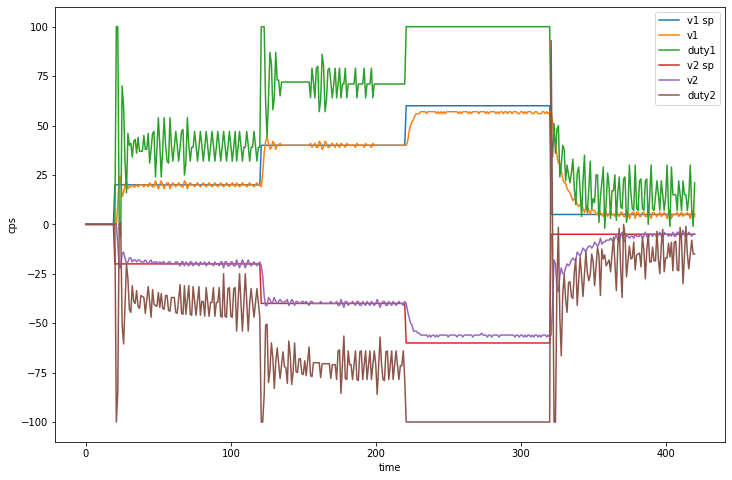

In [35]:
%%host

import matplotlib.pyplot as plt

_FSTATE_K       = const(0)
_FSTATE_VEL1    = const(1)
_FSTATE_VEL2    = const(2)
_FSTATE_VEL1_SP = const(3)
_FSTATE_VEL2_SP = const(4)
_FSTATE_DUTY1   = const(5)
_FSTATE_DUTY2   = const(6)
_FSTATE_SIZE    = const(7)


t       =  f_state[:, _FSTATE_K]
vel1    =  f_state[:, _FSTATE_VEL1]
vel2    =  f_state[:, _FSTATE_VEL2]
vel1_sp =  f_state[:, _FSTATE_VEL1_SP]
vel2_sp =  f_state[:, _FSTATE_VEL2_SP]
duty1   =  f_state[:, _FSTATE_DUTY1]
duty2   =  f_state[:, _FSTATE_DUTY2]

plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(t, vel1_sp)
plt.plot(t, vel1)
plt.plot(t, duty1)
plt.plot(t, vel2_sp)
plt.plot(t, vel2)
plt.plot(t, duty2)
plt.legend(('v1 sp', 'v1', 'duty1', 'v2 sp', 'v2', 'duty2'))

plt.xlabel("time")
plt.ylabel("cps");

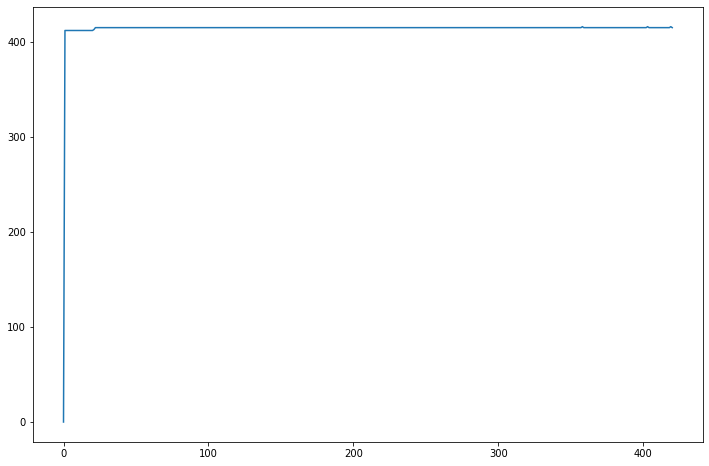

In [36]:
%%host

import matplotlib.pyplot as plt

_ISTATE_K       = const(0)
_ISTATE_DT      = const(1)
_ISTATE_ENC1    = const(2)
_ISTATE_ENC2    = const(3)

t       = i_state[:, _ISTATE_K]
dt      = i_state[:, _ISTATE_DT]

plt.plot(t, dt);